In [18]:
#code credits: Professor Richard Hull
# These are boiler plate imports that seem useful
# I should probably delete or comment out the ones that aren't used in this script...

import sys
import os
import subprocess
import shutil
# use shutil.rmtree(<path_to_folder>) to do an rm -r on the folder

import json
import csv
import yaml

import urllib

import pandas as pd
import numpy as np

import matplotlib as mpl
from cycler import cycler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# sys.path.append('/Users/rick/HACKING/UTILITIES_IN_HACKING/')
# import utils_general


# this one gives a warning - not fixing for now
# from owlready2 import *

# next function is used to generate timestamps that can be used to
# create uniquely named directories and/or files
import datetime
def curr_timestamp():
    current_datetime = datetime.datetime.now()
    formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
    return formatted_datetime


print('Initial imports successful')

Initial imports successful


In [19]:
# Using the URL of TIF file Land and Water Resources / Land Cover / Cropland 
# url = "https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/LR/lco/GLCSv11_02_5m.tif"

# Local directory to save the TIF file in
dir = "/Users/kavya/Documents/ECS289L/Project2/GAEZ/tif_files/"
tif_file_name = "tmp_IPSL-CM5A-LR_rcp8p5_2020s-2011-2040.tif"

# Fetch the TIF file using the URL
# urllib.request.urlretrieve(url, dir + tif_file_name)

In [12]:
val = " ".join(["gdalinfo", "-json", dir + tif_file_name])
print(val)
result = subprocess.run([val], shell=True, capture_output=True, text=True)

dict = json.loads(result.stdout)
print(json.dumps(dict, indent=2, sort_keys=True))

gdalinfo -json /Users/kavya/Documents/ECS289L/Project2/GAEZ/tif_files/tmp_IPSL-CM5A-LR_rcp8p5_2020s-2011-2040.tif
{
  "bands": [
    {
      "band": 1,
      "block": [
        256,
        256
      ],
      "colorInterpretation": "Gray",
      "max": 33.46,
      "maximum": 33.46,
      "mean": 10.122,
      "metadata": {
        "": {
          "STATISTICS_MAXIMUM": "33.459999084473",
          "STATISTICS_MEAN": "10.121764787918",
          "STATISTICS_MINIMUM": "-27.920000076294",
          "STATISTICS_STDDEV": "14.636816526915"
        }
      },
      "min": -27.92,
      "minimum": -27.92,
      "noDataValue": -99.0,
      "overviews": [
        {
          "size": [
            2160,
            1080
          ]
        },
        {
          "size": [
            1080,
            540
          ]
        },
        {
          "size": [
            540,
            270
          ]
        },
        {
          "size": [
            270,
            135
          ]
        }


In [20]:
def pull_useful(ginfo):  # should give as input the result.stdout from calling gdalinfo -json
    useful = {}
    useful['cornerCoordinates'] = ginfo['cornerCoordinates']
    useful['proj:transform'] = ginfo['stac']['proj:transform']
    useful['size'] = ginfo['size']
    useful['bbox'] = ginfo['stac']['proj:projjson']['bbox']
    useful['espgEncoding'] = ginfo['stac']['proj:epsg']
    return useful


useful = pull_useful(dict)
print(json.dumps(useful, indent=2, sort_keys=True))

{
  "bbox": {
    "east_longitude": 180,
    "north_latitude": 90,
    "south_latitude": -90,
    "west_longitude": -180
  },
  "cornerCoordinates": {
    "center": [
      -0.0,
      0.0
    ],
    "lowerLeft": [
      -180.0,
      -90.0
    ],
    "lowerRight": [
      180.0,
      -90.0
    ],
    "upperLeft": [
      -180.0,
      90.0
    ],
    "upperRight": [
      180.0,
      90.0
    ]
  },
  "espgEncoding": 4326,
  "proj:transform": [
    -180.0,
    0.0833333333333333,
    0.0,
    90.0,
    0.0,
    -0.0833333333333333
  ],
  "size": [
    4320,
    2160
  ]
}


In [38]:
# converting from lat/long into a pixel location for a global tif with size 4320x2160
def convert_to_pix(lon, lat):
    x = (lon + 180) * 12
    y = (90 - lat) * 12
    return x,y

dir = "/Users/kavya/Documents/ECS289L/Project2/GAEZ/tif_files/"
tif_file_name = "tmp_IPSL-CM5A-LR_rcp8p5_2020s-2011-2040.tif"


# x,y = convert_to_pix(-121.8,38.5) # Davis, CA
x,y = convert_to_pix(19.78, 3.244) # Gemena, D.R. Congo
# x,y = convert_to_pix(0,0) # in the ocean -- use this to test what the "nodata" value is; turns out it is 0

print(x,y)
val = " ".join(['gdallocationinfo', dir+tif_file_name, str(x), str(y)])
print(val)

result = subprocess.run([val], 
                         shell=True, capture_output=True,text=True)
print(result.stdout)
print(result.stderr)

2397.36 1041.0720000000001
gdallocationinfo /Users/kavya/Documents/ECS289L/Project2/GAEZ/tif_files/tmp_IPSL-CM5A-LR_rcp8p5_2020s-2011-2040.tif 2397.36 1041.0720000000001
Report:
  Location: (2397P,1041L)
  Band 1:
    Value: 25.6999988555908




In [39]:
import rioxarray as rxr

dir = "/Users/kavya/Documents/ECS289L/Project2/GAEZ/tif_files/"
tif_file_name = "tmp_IPSL-CM5A-LR_rcp8p5_2020s-2011-2040"
full_file_name = dir + tif_file_name + '.tif'

raster = rxr.open_rasterio(full_file_name, 
                               masked=True)

print("The datatype of raster is:", type(raster))

print("\nThe Coordinate Reference System (CRS) of your data is:", raster.rio.crs)
print("\nThe bounds of your data are:", raster.rio.bounds())
print("\nThe shape of your data is:", raster.shape)
print("\nThe spatial resolution for your data is:", raster.rio.resolution())
print("\nThe metadata for your data is:", raster.attrs)
print("\nThe nodatavalue of your data is:", raster.rio.nodata)

The datatype of raster is: <class 'xarray.core.dataarray.DataArray'>

The Coordinate Reference System (CRS) of your data is: EPSG:4326

The bounds of your data are: (-180.0, -90.0, 179.99999999999994, 90.0)

The shape of your data is: (1, 2160, 4320)

The spatial resolution for your data is: (0.08333333333333333, -0.08333333333333333)

The metadata for your data is: {'STATISTICS_MAXIMUM': 33.459999084473, 'STATISTICS_MEAN': 10.121764787918, 'STATISTICS_MINIMUM': -27.920000076294, 'STATISTICS_STDDEV': 14.636816526915, 'scale_factor': 1.0, 'add_offset': 0.0, 'units': 'unspecified'}

The nodatavalue of your data is: nan


In [41]:
from osgeo import gdal

dir = "/Users/kavya/Documents/ECS289L/Project2/GAEZ/tif_files/"
tif_file = "tmp_IPSL-CM5A-LR_rcp8p5_2020s-2011-2040.tif"

ds = gdal.Open(dir + tif_file)
print(ds)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fb0dad171e0> >


In [42]:
# following https://opensourceoptions.com/blog/gdal-python-tutorial-reading-and-writing-raster-datasets/

print("'ds' type", type(ds))
print()
print("Projection: ", ds.GetProjection())  # get projection
print()
print("Columns:", ds.RasterXSize)  # number of columns
print("Rows:", ds.RasterYSize)  # number of rows
print()
print("Band count:", ds.RasterCount)  # number of bands
print()
print("GeoTransform", ds.GetGeoTransform())

'ds' type <class 'osgeo.gdal.Dataset'>

Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]

Columns: 4320
Rows: 2160

Band count: 1

GeoTransform (-180.0, 0.08333333333333333, 0.0, 90.0, 0.0, -0.08333333333333333)


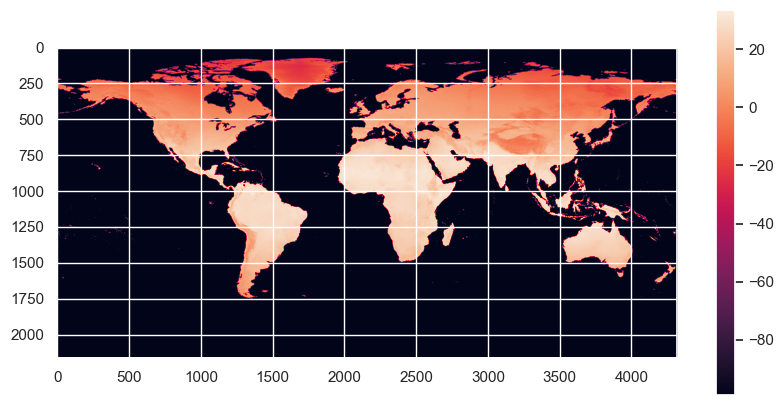

In [43]:
# standard colormaps listed at https://matplotlib.org/stable/tutorials/colors/colormaps.html

darray = np.array(ds.GetRasterBand(1).ReadAsArray())

plt.figure(figsize=(10,5))
plt.imshow(darray) 

# Using an alternative color map...
# plt.imshow(darray, cmap='cool')

plt.colorbar()
plt.show()

In [50]:
cmd = 'gdal_translate -projwin'
#39.2856,-122.1515 upper left 
#39.2896,-121.7084 upper right
#38.6845,-121.7559 lower left
#38.6819,-121.5623 lower right
leftLon = '-122.1515'
upperLat = '39.2896'
rightLon = '-121.5623'
lowerLat = '38.6819'
format = '-of GTiff'
source = '/Users/kavya/Documents/ECS289L/Project2/GAEZ/tif_files/tmp_IPSL-CM5A-LR_rcp8p5_2020s-2011-2040.tif'
target = '/Users/kavya/Documents/ECS289L/Project2/GAEZ/tif_files/tmp_IPSL-CM5A-LR_rcp8p5_2020s-2011-2040_c.tif'

val = " ".join([cmd, leftLon, upperLat, rightLon, lowerLat, format, source, target])
print(val)

result = subprocess.run([val], shell=True, capture_output=True, text=True)

print()
print(result.stdout)
print(result.stderr)

gdal_translate -projwin -122.1515 39.2896 -121.5623 38.6819 -of GTiff /Users/kavya/Documents/ECS289L/Project2/GAEZ/tif_files/tmp_IPSL-CM5A-LR_rcp8p5_2020s-2011-2040.tif /Users/kavya/Documents/ECS289L/Project2/GAEZ/tif_files/tmp_IPSL-CM5A-LR_rcp8p5_2020s-2011-2040_c.tif

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.




In [51]:
dir = "/Users/kavya/Documents/ECS289L/Project2/GAEZ/tif_files/"
clipped_file_name = "tmp_IPSL-CM5A-LR_rcp8p5_2020s-2011-2040_c.tif"

val = " ".join(["gdalinfo", "-json", dir + clipped_file_name])
print(val)
result = subprocess.run([val], shell=True, capture_output=True, text=True)

dict = json.loads(result.stdout)
# print(json.dumps(dict, indent=2, sort_keys=True))

useful = pull_useful(dict)
print(json.dumps(useful, indent=2, sort_keys=True))

gdalinfo -json /Users/kavya/Documents/ECS289L/Project2/GAEZ/tif_files/tmp_IPSL-CM5A-LR_rcp8p5_2020s-2011-2040_c.tif
{
  "bbox": {
    "east_longitude": 180,
    "north_latitude": 90,
    "south_latitude": -90,
    "west_longitude": -180
  },
  "cornerCoordinates": {
    "center": [
      -121.875,
      39.0416667
    ],
    "lowerLeft": [
      -122.1666667,
      38.75
    ],
    "lowerRight": [
      -121.5833333,
      38.75
    ],
    "upperLeft": [
      -122.1666667,
      39.3333333
    ],
    "upperRight": [
      -121.5833333,
      39.3333333
    ]
  },
  "espgEncoding": 4326,
  "proj:transform": [
    -122.16666666666667,
    0.0833333333333333,
    0.0,
    39.333333333333336,
    0.0,
    -0.0833333333333333
  ],
  "size": [
    7,
    7
  ]
}


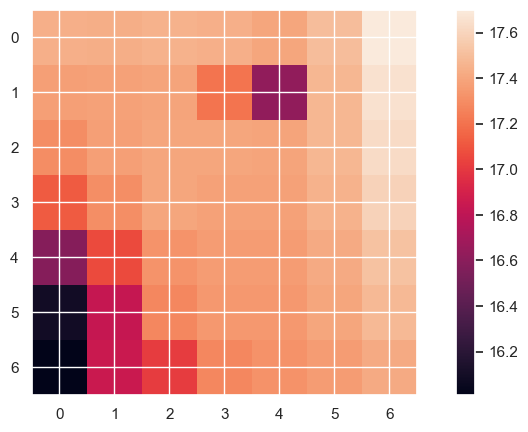

In [52]:
dsc = gdal.Open(dir + clipped_file_name)

dcarray = np.array(dsc.GetRasterBand(1).ReadAsArray())

plt.figure(figsize=(10,5))
plt.imshow(dcarray) 

plt.colorbar()
plt.show()

In [57]:
dcarray

array([[17.44    , 17.43    , 17.449999, 17.44    , 17.4     , 17.5     ,
        17.699999],
       [17.369999, 17.38    , 17.39    , 17.21    , 16.63    , 17.47    ,
        17.66    ],
       [17.3     , 17.369999, 17.4     , 17.4     , 17.39    , 17.47    ,
        17.63    ],
       [17.119999, 17.31    , 17.4     , 17.38    , 17.38    , 17.449999,
        17.59    ],
       [16.58    , 17.06    , 17.33    , 17.359999, 17.359999, 17.42    ,
        17.52    ],
       [16.09    , 16.83    , 17.279999, 17.35    , 17.35    , 17.4     ,
        17.48    ],
       [16.01    , 16.85    , 17.02    , 17.279999, 17.32    , 17.359999,
        17.42    ]], dtype=float32)